In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Torch imports
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from ignite.metrics import PSNR, SSIM
from ignite.engine import *
from torchmetrics.image.kid import KernelInceptionDistance

# Import diffusion model
from pytorch_diffusion.diffusion import get_beta_schedule, Diffusion

# imports for plotting
import PIL
from skimage import io
import matplotlib.pyplot as plt
from IPython.display import Image

# For progess bar
from tqdm import tqdm

# Costum imports
from utils.degradation import Degradation, UniformBlur, Noising
from utils.data_utils import plot_batches, set_device, eval_step
from utils.ddrm import DDRM


# Testing if import worked correctly
# device = set_device('cpu')
device = set_device()


Using device: mps:0


In [24]:
from torchvision.datasets.lsun import LSUN, LSUNClass
import torchvision.transforms as transforms
import torch
from tqdm import tqdm


In [25]:
# Initialise Hyperparameters
batch_size = 4
kernel_size=(9,9)
image_size=(256,256)

eta = 0.85
eta_b = 1
n_steps = 20
time_steps=1000

std = 0.1


In [26]:
# degradation_model = Noising(device=device, std=std)
degradation_model = UniformBlur(device=device, std=std)

In [27]:
# Define metrics for evaluation of model performance
default_evaluator = Engine(eval_step)

# PSNR Score
psnr = PSNR(data_range=1, device='cpu')
psnr.attach(default_evaluator, 'psnr')

# SSIM Score
ssim = SSIM(data_range=1, kernel_size=kernel_size)
ssim.attach(default_evaluator, 'ssim')

In [28]:
data_dir = './data/ddrm-exp-datasets-main/'

data = ImageFolder(
    root=data_dir,
    transform=transforms.Compose([
        transforms.PILToTensor(),
        transforms.Resize(image_size),
        ])
)

data_loader = DataLoader(
    data,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

print(f'Length of Dataset: {data.__len__()}')
print(f'Length of DataLoader: {data_loader.__len__()}')

Length of Dataset: 41
Length of DataLoader: 10


In [29]:
name = "lsun_church"
# name = "image_net"

diffusion = DDRM.from_pretrained(name, device=device, num_timesteps=time_steps)
hyperparams = dict(sigma_y = std, eta = eta, eta_b =  eta_b, n_steps = n_steps)


Instantiating
Loading checkpoint /Users/dalimwahby/.cache/diffusion_models_converted/diffusion_lsun_church_model/model-4432000.ckpt
Moved model to mps


In [30]:
# Run evaluation of model
debug_mode = True

# Lists for storing scores of baseline
psnr_baseline, ssim_baseline = [], []

# Lists for storing scores of DDRM
psnr_ddrm, ssim_ddrm = [], []

for i, batch in enumerate(tqdm(data_loader)):
  batch = (batch[0]/255).to(device)
  
  if batch.shape[0] != batch_size:
    continue

  # Degrade the sample
  degraded_batch = degradation_model(batch)
  

  # Denoise and deblurr the sample
  reconstructed, steps = diffusion.denoise(batch_size, 
                              degraded_batch,
                              n_steps=n_steps,
                              degradation_model = degradation_model,  
                              hyperparams=hyperparams)
  

  y = batch.cpu()
  y_degraded = degraded_batch.cpu()
  y_pred = reconstructed.cpu()
  
  # Compute PSNR and SSID, then append to score lists
  state_baseline = default_evaluator.run([[y, y_degraded]])
  psnr_baseline.append(state_baseline.metrics['psnr'])
  ssim_baseline.append(state_baseline.metrics['ssim'])

  state_ddrm = default_evaluator.run([[y_pred, y]])
  psnr_ddrm.append(state_ddrm.metrics['psnr'])
  ssim_ddrm.append(state_ddrm.metrics['ssim'])
  
  if debug_mode: 
    # plot_batches([batch, degraded_batch, reconstructed])
    break


print('-------------------| Baseline |-------------------')
print(f'# Samples: {len(psnr_baseline)*batch_size}')
print(f'Mean PSNR: {sum(psnr_baseline)/len(psnr_baseline)}')
print(f'Mean SSIM: {sum(ssim_baseline)/len(ssim_baseline)}')

print('---------------------| DDRM |---------------------')
print(f'Mean PSNR: {sum(psnr_ddrm)/len(psnr_ddrm)}')
print(f'Mean SSIM: {sum(ssim_ddrm)/len(ssim_ddrm)}')

  0%|          | 0/10 [00:36<?, ?it/s]

-------------------| Baseline |-------------------
# Samples: 4
Mean PSNR: 17.780587380722693
Mean SSIM: 0.14878036279873808
---------------------| DDRM |---------------------
Mean PSNR: 24.71889151532332
Mean SSIM: 0.6701048569640209


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


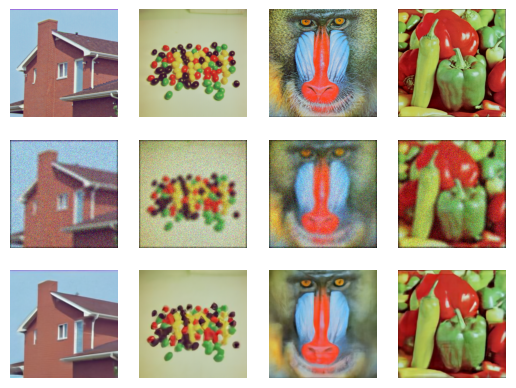

In [31]:
plot_batches([batch, degraded_batch, reconstructed])